In [3]:
import os
import sys

current_dir =  os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
import pyro
from collab import foraging_toolkit as ft
import torch.nn.functional as F
import logging
import time
import dill
import copy

from scipy.signal import find_peaks

import plotly.io as pio
from plotly import express as px, graph_objects as go, figure_factory as ff
from pyro.nn import PyroModule
import pyro.distributions as dist
from pyro.infer.autoguide import (
    AutoNormal,
    AutoDiagonalNormal,
    AutoMultivariateNormal,
    init_to_mean,
    init_to_value,
)


from pyro.contrib.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS
from pyro.optim import Adam
import pyro.optim as optim
from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS


In [4]:
ducks_raw = pd.read_csv('../data/central_park_birds_cleaned_2022/20221215122046189_-5_25_bone.avi.hand_checked_cleaned_df.csv')
sparrows_raw = pd.read_csv('../data/central_park_birds_cleaned_2022/20221229124843603_n5_25_bone.avi.hand_checked_cleaned_df.csv')

display(ducks_raw.head())
display(sparrows_raw.head())

print(ducks_raw.shape)
print(sparrows_raw.shape)

,x,y,time,bird
0,84.853396,22.812170,0,1
1,308.485824,22.659691,0,2
2,75.273170,91.047143,0,12
3,68.939135,99.259521,0,17
4,155.181453,109.061447,0,20


,x,y,time,bird
0,294.843352,82.777842,0,2
1,110.659049,86.254356,0,3
2,6.545799,136.260651,0,11
3,294.693470,83.130834,1,2
4,110.614951,86.297426,1,3


(8867, 4)
(22821, 4)


In [5]:
1450/5

11549/5

2309.8

In [6]:
# tweak frames to obtain similar dataset sizes

ducks_sub = ft.subsample_frames_evenly_spaced(ducks_raw, 300)
ducks_sub = ft.rescale_to_grid(ducks_sub, 90)
ducks_obj = ft.object_from_data(ducks_sub, grid_size=90, frames=300,
                                calculate_step_size_max = True)




sps_sub = ft.subsample_frames_evenly_spaced(sparrows_raw, 2300)
print(sps_sub['bird'].unique())
sps_sub = sps_sub[sps_sub['time']<=800]
sps_sub = ft.rescale_to_grid(sps_sub, 90)
sps_obj = ft.object_from_data(sps_sub, grid_size=90, frames=300,
                              calculate_step_size_max = True)

print(sps_sub['time'].max())
print(sps_sub['bird'].unique())
print("len_ducks_sub: ", len(ducks_sub))
print("len sps_sub: ", len(sps_sub))    

original_frames: 1450
original_shape: (8867, 4)
resulting_frames: 300
resulting_shape: (1858, 4)
min_time 1
max_time 300
original_frames: 11549
original_shape: (22821, 4)
resulting_frames: 2300
resulting_shape: (4562, 4)
min_time 1
max_time 2300
[ 2  3 11 26 27 10 21 25  4  5  6 22  7  8 23  9 12 13 24 14 15 16 17  0
 18 19  1 20]
800
[ 2  3 11 26 27 10 21 25  4  5  6 22  7  8]
len_ducks_sub:  1858
len sps_sub:  1810


In [7]:
sps_obj.birdsDF.shape

(1810, 4)

In [8]:
# these are max shifts along an axis
# sparrows et al. seem more jumpy
print(ducks_obj.step_size_max)
print(sps_obj.step_size_max)


6.0
25.0


In [9]:
#let's get a feel for the distance distribution of ducks
duck_distances = ft.cp_birds_to_bird_distances(ducks_obj)


In [10]:
sps_distances = ft.cp_birds_to_bird_distances_sps(sps_obj)

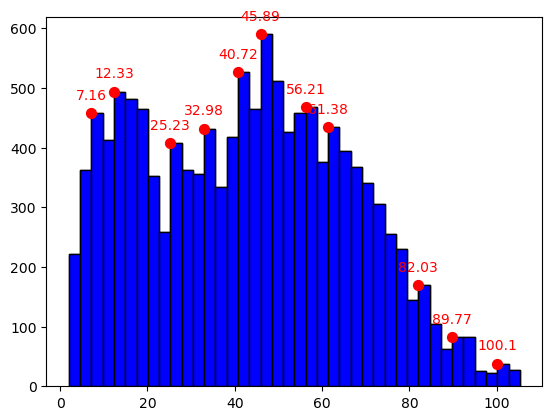

In [11]:
ft.cp_distances_and_peaks(duck_distances)

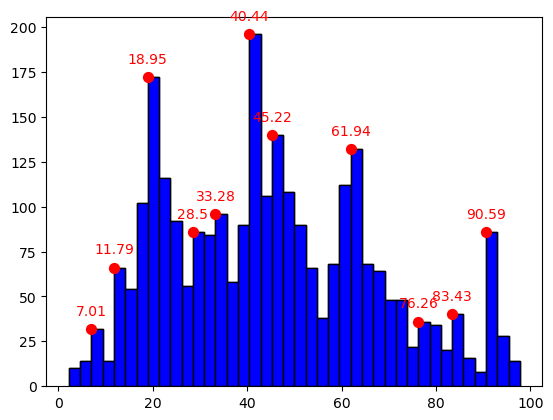

In [12]:
# now sparrows et al.
ft.cp_distances_and_peaks(sps_distances)

# we will use 19, 46, and 84 as proximity hyperparameters
# 19 should work well for sparrows, less so ducks
# 46 should work well for ducks, not terribly for sparrows
# 85 should not work very well for either

In [13]:
# note were severely subsampling the grid here, mostly for speed

ducks_vis = ft.cp_generate_visibility(ducks_obj.birds, sampling_rate=0.02)
ducks_obj.visibility = ducks_vis["visibility"]
ducks_obj.visibilityDF = ducks_vis["visibilityDF"]

sps_vis = ft.cp_generate_visibility(sps_obj.birds, sampling_rate=0.02)
sps_obj.visibility = sps_vis["visibility"]
sps_obj.visibilityDF = sps_vis["visibilityDF"]

In [14]:
# now the combinations we want
# this is a longish process, so we'll save the results
# and if you don't want to run it, just load them  from (cell below)

def cp_derive(obj, optimal_list, bird_distances = None):

    objects = {}
    
    
    for optimal in optimal_list:
        prox = ft.cp_generate_proximity_score(
        obj,
        visibility_range=100,
        getting_worse=2,
        optimal=optimal,
        proximity_decay=0.1,
        time_shift=0,
        bird_distances = bird_distances)
    
        _obj = copy.copy(obj)
        _obj.proximity = prox["proximity"]
        _obj.proximityDF = prox["proximityDF"]
        ft.cp_add_how_far_squared_scaled(_obj)
    
        objects[optimal] = _obj   
    
    return objects
    


In [15]:
        
ducks_objects = cp_derive(ducks_obj, [19, 46, 85])


In [16]:

def cp_derive_sps(obj, optimal_list, bird_distances = None):

    objects = {}
    
    
    for optimal in optimal_list:
        prox = ft.cp_generate_proximity_score_sps(
        obj,
        visibility_range=100,
        getting_worse=2,
        optimal=optimal,
        proximity_decay=0.1,
        time_shift=0,
        bird_distances = sps_distances)
    
        _obj = copy.copy(obj)
        _obj.proximity = prox["proximity"]
        _obj.proximityDF = prox["proximityDF"]
        ft.cp_add_how_far_squared_scaled(_obj)
    
        objects[optimal] = _obj   
    
    return objects
    

In [17]:
sps_objects = cp_derive_sps(sps_obj, [19, 46, 85])

In [18]:

central_park_objects = [ducks_objects, sps_objects]


In [19]:

path = "../data/central_park_birds_cleaned_2022/central_park_objects.pkl"
with open(path, "wb") as file:
    dill.dump(central_park_objects, file)


In [20]:
def trajectory_plot(data, rewards, max_time, xrange = [0, 30], yrange = [0, 30], title = ""):
    
    data = data[data['time'] <= max_time]

    df = data
    # jitter x and y
    df['x'] = df['x'] + np.random.normal(0, .2, len(df))
    df['y'] = df['y'] + np.random.normal(0, .2, len(df))

    # smooth x and y
    df['x'] = df['x'].rolling(3, min_periods=1).mean()
    df['y'] = df['y'].rolling(3, min_periods=1).mean()

    fig = px.line(df, x='x', y='y', color='bird', width = 700, height = 700, template='presentation', title = title)
    

    # add rewards
    if len(rewards) > 0:
        rewards = rewards[rewards['time'] <= max_time]
        fig.add_trace(go.Scatter(
                x=rewards['x'],
                y=rewards['y'],
                mode='markers', 
                marker={'symbol': 'square', 
                    'size': 10,
                    'color': 'yellow',
                    'line': {'width': 2, 'color': 'yellow'}}))

    fig.data = fig.data[::-1] # reverse the order of the traces

    # axis image, and 30x30 axis lims
    fig.update_xaxes(range=xrange)
    fig.update_yaxes(range=yrange)


    # remove legend and x labels and ticks
    fig.update_layout(
        showlegend=False,
    )
    fig.show()
    return fig

In [22]:
trajectory_plot(ducks_obj.birdsDF, [], 800, xrange = [0, 30], yrange = [0, 30], title = "Ducks")

TypeError: list indices must be integers or slices, not str